### Osceola CFLRP 


#### Required libraries
and data directories

In [1]:
# Load required libraries and establish data directories

# ------- Notebook config
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib

# ------- Load dependencies
import pandas as pd
import numpy as np
import seaborn as sns
import gdal, os, osr
from scipy import stats
import random
import ast
import csv



# ---- Map dependencies
import fiona
from shapely.geometry import Point, Polygon, MultiPoint, MultiPolygon
from shapely.prepared import prep
from descartes import PolygonPatch
from itertools import chain
from mpl_toolkits.basemap import Basemap
from matplotlib.collections import PatchCollection


dataDir = 'Z:/Dan K/Osceola/'
rasterDir = dataDir + 'Ecoregion Generation/Rasters/'
shapeDir = dataDir + 'Ecoregion Generation/Shapefiles/'

sns.set_style("ticks")
sns.set_context('notebook', font_scale=1.5)

:0: FutureWarning: IPython widgets are experimental and may change in the future.


#### Define some custom functions 
These will soon be wrapped up into a module to clean up the notebooks


In [2]:
def importRaster(rasterPath, **kwargs):
    # Open and read in the raster as an array
    raster_ds = gdal.Open(rasterPath)
    rastermap = raster_ds.ReadAsArray()
    
    # Set the default data type to 'float'
    if 'dtype' not in kwargs:
        dtype = 'float'
    rastermap = rastermap.astype(dtype)
    
    # If specified, set the no data value to NaN
    if 'noData' in kwargs:
        rastermap[rastermap == noData] = np.nan
    return rastermap

def plotRaster(image, ax=None, *args, **kwargs):

    # Grab figure axes if none stated
    if ax == None:
         ax = plt.gca()
                   
    # Normalize color scheme
    if 'norm' not in kwargs:
        vmin = kwargs.pop('vmin', None)
        vmax = kwargs.pop('vmax', None)
        if vmin is None:
            vmin = np.min(image) # or what ever
        if vmax is None:
            vmax = np.max(image)
        norm = matplotlib.colors.Normalize(vmin, vmax)
        kwargs['norm'] = norm

    #ax.figure.canvas.draw() # if you want to force a re-draw
    ax.imshow(image, *args, **kwargs)
    # Setup axes
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])
    
def getShpGeom(shapefile):
    shp = fiona.open(shapefile)
    bds = shp.bounds
    shp.close()
    padLON = ((bds[0] - bds[2]) / 2) * 0.05
    padLAT = ((bds[1] - bds[3]) / 2) * 0.05
    ll = (bds[0] + padLON, bds[1] + padLAT)
    ur = (bds[2] - padLON, bds[3] - padLAT)
    midlat = (bds[1] + bds[3]) / 2
    midlon = (bds[0] + bds[2]) / 2
    coords = list(chain(ll, ur))
    return coords, midlat, midlon

def saveAsGeoTiff(spatialRaster, ndarray, outputFileName, epsg):
    templatedf = gdal.Open(spatialRaster)
    template = templatedf.ReadAsArray()
    driver = gdal.GetDriverByName('GTiff')
    outputRaster = driver.Create(outputFileName,
                                 template.shape[1],
                                 template.shape[0],
                                 1, gdal.GDT_Int32)
    
    srs = osr.SpatialReference()
    srs.ImportFromEPSG(epsg)
    dest_wkt = srs.ExportToWkt()
    
    outputRaster.SetGeoTransform(templatedf.GetGeoTransform())
    outputRaster.GetRasterBand(1).WriteArray(ndarray)
    outputRaster.SetProjection(dest_wkt)

    outputRaster.FlushCache()

#### Define the analysis extent
The Osceola national forest is in north Florida. The extent of the forest that will actually be simulated is shown below with the context map of Florida.

C:\Anaconda\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


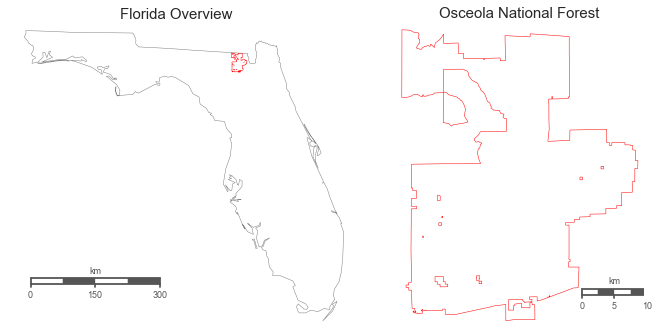

In [4]:
f, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
sns.set_style('white')
sns.despine(left = True, bottom = True)

coords, midlat, midlon = getShpGeom(shapeDir + 'Florida_State.shp')

m = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax1);

m.readshapefile(shapeDir + 'Florida_State', 'Florida',
    color='gray', zorder=5);
m.readshapefile(shapeDir + 'OsceolaShape', 'Osceola',
    color='red', zorder=5);


m.drawmapscale(
    coords[0]+2, coords[1]+1,
    coords[0], coords[1],
    300.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

coords, midlat, midlon = getShpGeom(shapeDir + 'OsceolaShape.shp')

m1 = Basemap(llcrnrlon=coords[0],llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax2);

m1.readshapefile(shapeDir + 'OsceolaShape', 'Osceola',
    color='red', zorder=5);

m1.drawmapscale(
    coords[0] + 0.35, coords[1] + 0.05,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

ax1.set_title('Florida Overview', fontsize = 15)
ax2.set_title('Osceola National Forest', fontsize = 15)
plt.tight_layout()
plt.savefig('AreaOverview.tif')

#### Ecoregion generation
First step toward building the Osceola into LANDIS-II is to generate ecoregions -- climatically and edaphically similar areas, wherein soil and climate will provide the same drivers for vegetation growth. The Osceola isn't a huge area (~90k ha) and also is not exceptionally mountainous. This should make creating ecoregions a simple affair. 

The strategy will be to leverage GSSURGO data to describe the major soil types across the landscape, and look for differences in for example water holding capacity. Then we will overlay those differences with crude elevation bands, using elevation as a surrogate for climate -- so long as precipitation and temperature appear to vary across an elevation gradient within the study area.

####GSSURGO data
This always gives me a headache. So here are the steps I used to make sense of the GSSURGO data once its downloaded. I downloaded the data from https://gdg.sc.egov.usda.gov/ on 8-28-2016
1. Load the MapunitRaster into a GIS of your  choice
2. Import two data tables, 'chorizon' and 'component'. I don't understand the naming convention here, chorizon isn't a word, so presumably this stands for c horizon, as the table has a lot of soil horizon data -- clay, sand, silt at various depths etc. However the same logic cannot be applied to 'component', as c omponent doesn't make any sense...
3. Create a spatial join between the MapunitRaster and 'component' using 'MUKEY' from the MapunitRaster (presumably standing for Mapunit Key) and 'Mapunit Key' from 'component'. Why both columns aren't called the same thing, when in fact they represent the same data ...
4. Create a spatial join between MapunitRaster and 'chorizon' using the newly acquired 'Component Key' from MapunitRaster.component. 'chorizon' has the same name for its 'Component Key' column, just to futher add to the confusion via a moment of clarity.
5. Now you have access to the spatial data from 'chorizon' and 'component' on a per MapunitRaster basis.
6. If you want to access the parent group material, useful for splitting up the analysis area into edaphically dissimilar chunks, you need to access the 'copm' table. To make use of it, you need to join it to the MapunitRaster via the 'Component Parent Material Group Key' attribute, which doesn't exist in any of the tables we've joined so far. So, we need an intermediate join that speaks both languages -- namely 'copmgrp'. By joining 'copmgrp' to MapunitRaster via 'Component Key', we can access the parent material columns spatially via our MapunitRaster layer.

The next step isn't entirely intuitive either -- clipping the resulting geodatabase to a smaller vector (e.g., clipping the GSSURGO data for all of FL to just the Osceola extent) requires clipping the 'MUPOLYGON' feature inside the GSSURGO geodatabase. In that manner you end up with a clipped .gdb that retains all associations with the MUKEY and consequently Mapunit Key fields, which you can still relate to soil properties following the steps above.

#### Take a look at edaphic patterns
that might explain some of the variability in soils across the Osceola. Here, sand, silt, and clay content varies spatially, with some start differences across the center of the region. So stark that its probably not real -- I'm half guessing, but i'd wager that this is an artifact of the spatial averaging that goes on within the gSSURGO data. But, its really not that big of a deal, given the tiny range of variability were dealing with. 

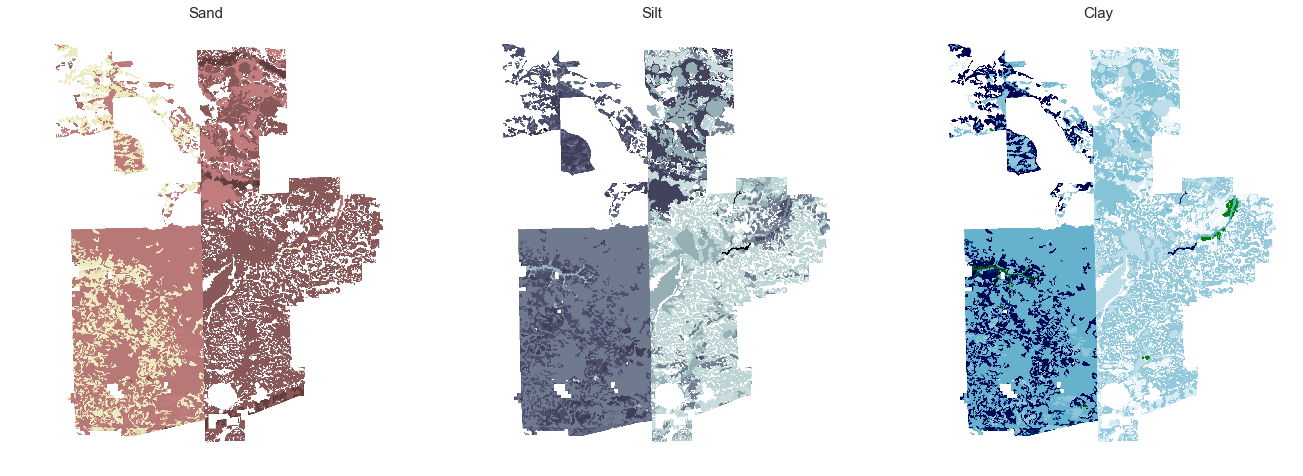

In [5]:
sand = importRaster(rasterDir + 'osceola_sand.tif')
silt = importRaster(rasterDir + 'osceola_silt.tif')
clay = importRaster(rasterDir + 'osceola_clay.tif')

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (24,8))
plotRaster(sand, ax1, cmap = 'pink_r', vmin = 70, vmax = 100)
plotRaster(silt, ax2, cmap = 'bone_r', vmin = 0, vmax = 10)
plotRaster(clay, ax3, cmap = 'ocean_r', vmin = 0, vmax = 25)
plt.subplots_adjust(wspace = 0, hspace = 0.05)
for ax in f.axes:
    ax.set_xticklabels('')
    ax.set_yticklabels('')
ax1.set_title('Sand', fontsize = 15)
ax2.set_title('Silt', fontsize = 15)
ax3.set_title('Clay', fontsize = 15)
plt.savefig('Sand_Silt_Clay.tif')

#### Water holding capacity
GSSURGO data doesn't ship out with a depth normalized water holding capcity product, but you can calculate one using the available water holding capacity columns, and some combination of soil depth columns. I basically normalized AWC by the representative bottom and top soil depths. We see some residual impacts of the spatial abbheration above, albeit a small signal.

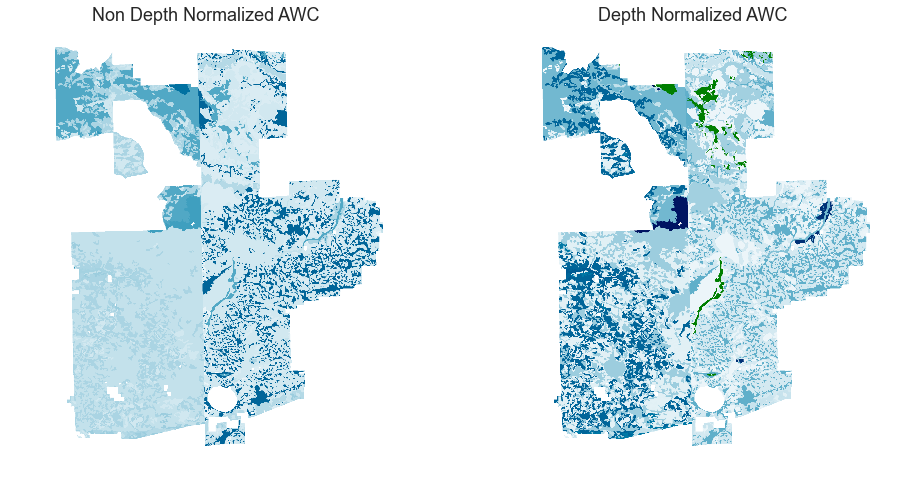

In [6]:
whc = importRaster(rasterDir + 'osceola_whc.tif')
awc = importRaster(rasterDir + 'osceola_awc.tif')

f, (ax1, ax2) = plt.subplots(1,2, figsize = (16,8))
plotRaster(awc, ax1, cmap = 'ocean_r', vmin = 0, vmax = 1)
plotRaster(whc, ax2, cmap = 'ocean_r', vmin = 0, vmax = 25)

ax1.set_title('Non Depth Normalized AWC');
ax2.set_title('Depth Normalized AWC');

plt.savefig('Osceola_WaterHolding.tif')

#### Lets look at the elevation across the region
I grabbed a state wide Lidar mosaic from http://www.fgdl.org/ on 8-28-2016. The data came with a metadata vector that indicated the data were acquired in 2013 by the FWC. There are a bunch of holes, some small and some large -- the large holes are mostly meant to be absent, and others are actual holes in the lidar data.  We want to fill the some no data holes, and keep the others. The approach will be to take a focal mean of the raw data, then clip the raw data with a shapefile of the Osceola -- that way the actual holes will be re-stamped out of the filled / smoothed DEM.

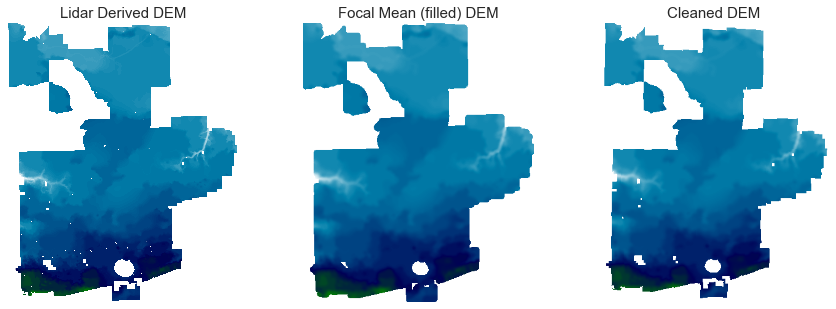

In [7]:
elev = importRaster(rasterDir + 'osceola_lidar.tif')
elev_f = importRaster(rasterDir + 'OsceolaLidar_Filled.tif')
elev_fc = importRaster(rasterDir + 'OsceolaLidar_Filled_Clip_R.tif')

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plotRaster(elev, ax1, cmap = 'ocean_r', vmin = 90, vmax = 200);
plotRaster(elev_f, ax2, cmap = 'ocean_r', vmin = 90, vmax = 200);
plotRaster(elev_fc, ax3, cmap = 'ocean_r', vmin = 90, vmax = 200);

ax1.set_title('Lidar Derived DEM', fontsize = 15);
ax2.set_title('Focal Mean (filled) DEM', fontsize = 15);
ax3.set_title('Cleaned DEM', fontsize = 15);
plt.savefig('OsceolaElevationHoles.tif')

#### After spatially resampling all datasets and normalizing projections
There is still some inconsistency in the number of pixels per raster layer. This stems from the fact that we were taking raster data from two different sources (gSSURGO and Lidar) and clipping them with the same vector. No big deal, we resampled everything to 100x100 meter grids, then forced the number of rows and columns to equate to the dimensions of the lidar data. This forced the gssurgo products to actually have a non-100 x 100 meter dimension (more like 98.6 x 99.6 or something like that). Thats fine, we're only using it to aggregate edaphic data to the ecoregion scale.

#### Now to create ecoregions
We have information about water holding capacity, which is a function of sand, silt, and clay -- normalized by soil depth. We also have information about elevation, inherent to which is some relative upland vs lowland soil moisture. Really there is an incredible lack of variability in this system topographically, but by crossing 'uplands vs lowlands' with 'low and high WHC', we can capture whatever gradients might exist in reality.

In [8]:
# Create a copy of the elevation raster
elevBins = importRaster(rasterDir + 'OsceolaLidar_Filled_Clip_R.tif')
elevBins[(elev_fc > 0) & (elev_fc < 130)] = 10
elevBins[elev_fc >= 130] = 25

# Create two copies of the WHC raster -- one to reference and one to reclass. 
whc = importRaster(rasterDir + 'OsceolaWHC.tif')
whcBins = importRaster(rasterDir + 'OsceolaWHC.tif')
whcBins[(whc > 0) & (whc < 7)] = 35
whcBins[whc >= 7] = 55

# Create the 'Ecoregion' raster by addition
Ecoregions = elevBins + whcBins

# This addition results in 9 unique values
# (0.,  10.,  25.,  35.,  45.,  55.,  60.,  65.,  80.)
# We only want to keep values that resulted from addition, all else can
# be given a 0 value
Ecoregions[Ecoregions < 26] = 0
Ecoregions[(Ecoregions == 35) | (Ecoregions == 55)] = 0

# Reclassify
Ecoregions[Ecoregions == 45] = 1
Ecoregions[Ecoregions == 60] = 2
Ecoregions[Ecoregions == 65] = 3
Ecoregions[Ecoregions == 80] = 4

#### The result is four ecoregions -- uplands x lowlands, high whc x low whc
Before we can plot it and have it look nice, we need to mask out the 0 values. When we export the raster as a geotiff however, we need to make sure we include them.

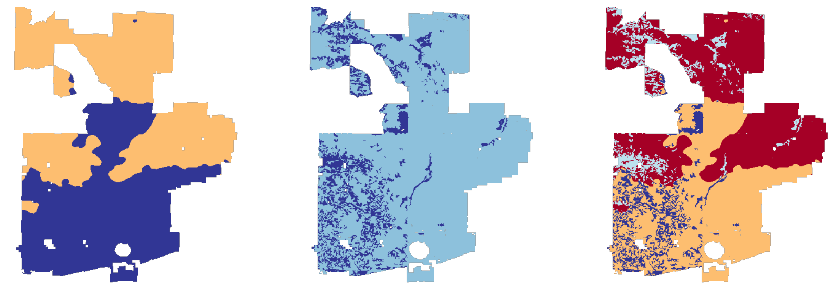

In [9]:
#Mask for plot
Ecoregions[Ecoregions == 0] = np.nan
elevBins[elevBins == 0] = np.nan
whcBins[whcBins == 0] = np.nan

f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (15,5))
plotRaster(elevBins, ax1,cmap = 'RdYlBu', vmin = 5, vmax = 20)
plotRaster(whcBins, ax2,cmap = 'RdYlBu', vmin = 20, vmax = 40)
plotRaster(Ecoregions, ax3, cmap = 'RdYlBu', vmin = 1, vmax = 4)

#### Four ecoregions may even be too many
given the lack of topographic relief in the area, and consequent relative homogeneity of the soils. But, given that the differences we are parsing out are small, the resulting effect on impacting how the model simulates vegetation growth should also be small. 

The next step is to export the raster as a geotiff, then vectorize the layer and appropriate climate data.

In [10]:
saveAsGeoTiff(rasterDir + 'OsceolaLidar_Filled_Clip_R.tif', 
              Ecoregions, rasterDir + 'Osceola_Ecoregions.tif', 26917)

### Following our trip to the Osceola ...
We learned about a couple helpful things. Primarily, this forest is essentially a pine plantation with demographic homogeneity more a function of planting date than anything else. Further, the ecoreigons are essentially 'Swamp' and 'Not Swamp'. Further, we were able to get the fire history for the area as well as a 'burnable' and 'wetlands' layer.

This changes the approach a bit, and basically creates a two ecoregion scenario: swamp and not swamp. Sure makes things simple though, leaving the only major challenge to handle the fuels flammability bifurcation as a function of fire weather.

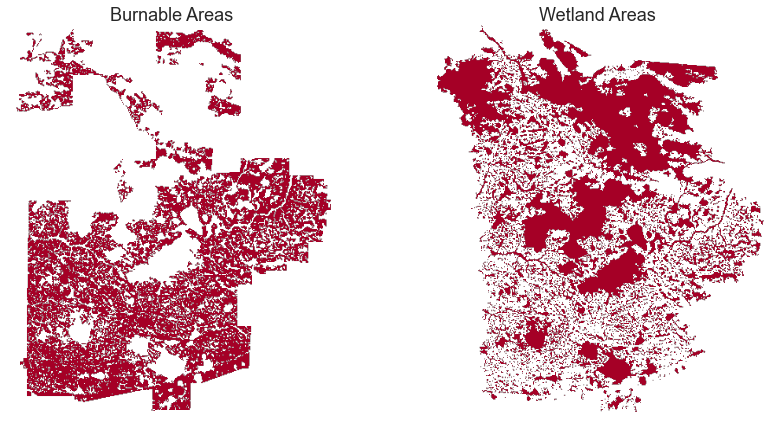

In [11]:
burnableArea = importRaster('H:\BurnableArea.tif')
wetlandArea = importRaster('H:\WetlandAreas.tif')

burnableArea[burnableArea == 255] = np.nan
wetlandArea[wetlandArea == 255] = np.nan

f, (ax1, ax2) = plt.subplots(1,2, figsize = (14,7))
plotRaster(burnableArea, ax = ax1, cmap = 'RdYlBu')
plotRaster(wetlandArea, ax = ax2, cmap = 'RdYlBu')
ax1.set_title('Burnable Areas')
ax2.set_title('Wetland Areas')

### By combining the burnable and wetland layers...
and clipping by the Osceola boundary, we get the final ecoregions for the simulation. Light green are wetland areas that will draw from wetland FIA data. Dark green are non saturated areas, that will have species and age compositions informed by both FIA and Osceola forest unit stand ages (planting date).

Int values of 1 are burnable area (pine plantation with palmetto understory). Int values of 2 are swamplands (Cyprus, Oak, and Sweetgum overstory with Oaky shrub understory).

#### These regions are also our fire regions
which is super convenient

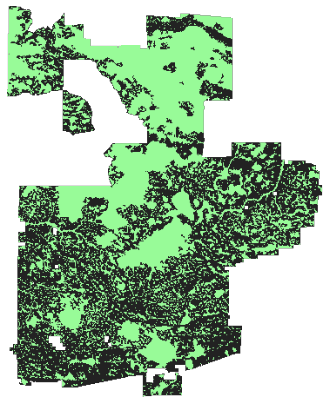

In [12]:
osceolaEcoregions = importRaster('H:\OsceolaEcoregions.tif')
colors = ["windows blue", "amber", "greyish", "faded green", "dusty purple"]
ecoPal = sns.dark_palette("palegreen", as_cmap=True)

osceolaEcoregions[osceolaEcoregions == 0] = np.nan
f, (ax1) = plt.subplots(1,1, figsize = (7,7))
plotRaster(osceolaEcoregions, ax = ax1, cmap = ecoPal, vmin = 1, vmax = 2)


### Ecoregion Sand, Silt, and Clay means by ecoregion
The sand, silt, and clay rasters from above are still useful, and by running zonal stats on the new and improved ecoregion raster above, we can create table means for the parameters that will inform the soil component of the model.

### Parameter scavenger hunt
Complete mess looking for southern pine physiological parameters. I grabbed what I could from the obvious sources, hunted throug the less obvious sources, and then got inventive. We will need to take a look at everything in the model params to make sure it seems reasonable, but for now everything runs and doesnt look broken so its a decent starting spot. JPGs of the tables will be thrown in here for completeness once the paper is out for review.

### Single cell output
Lets take a quick look at some of the single cell runs and do a quick gut check. This was generated using spin up historic climate from CCSM LOCA v2 projections. 

Cohorts of longleaf and slashpine at 40 and 10 years each. 

The palmetto cohorts are set to 20, 40, and 60.

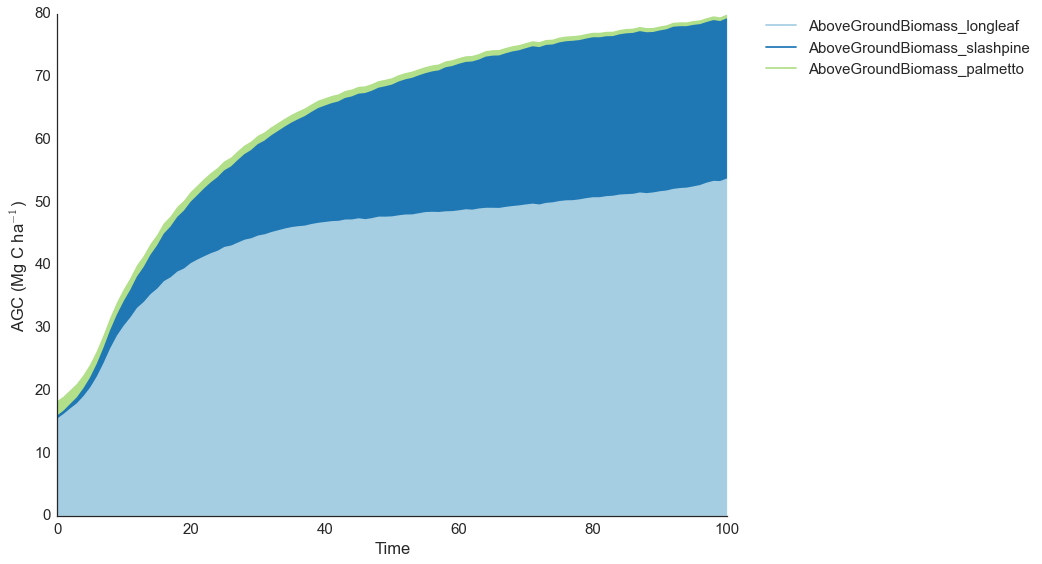

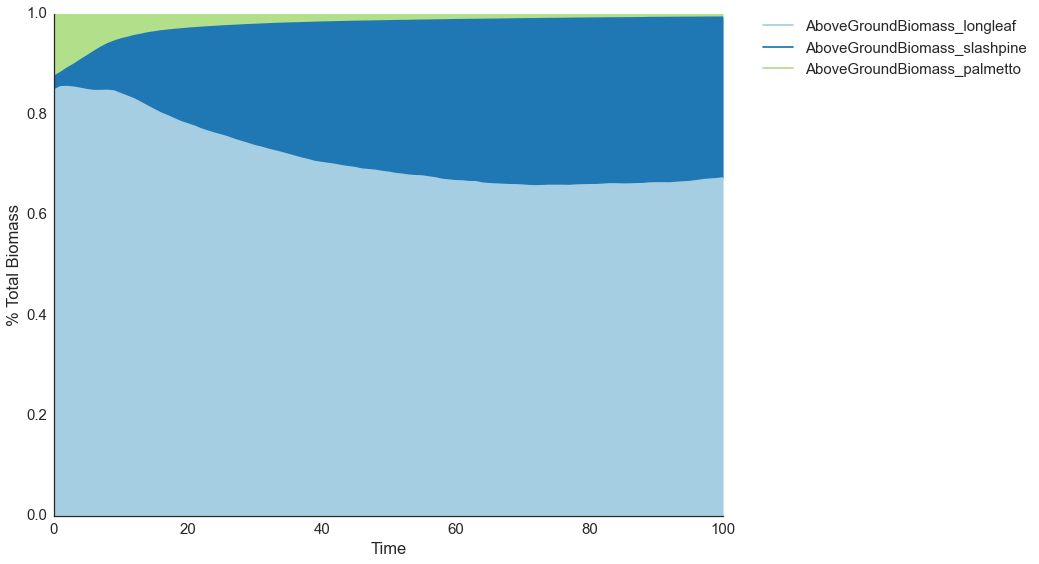

In [13]:
wrkDir = 'C:/Research/Osceola/SingleCell/MixedPine/'

# Read in century output, delete any erronious columns
centuryOutput = pd.read_csv(wrkDir + 'NECN-succession-log.csv')
for col in centuryOutput.columns:
    if 'Unnamed' in col:
        del centuryOutput[col]

# Read in the species biomass log, delete any erronious columns
sppBio = pd.read_csv(wrkDir + 'spp-biomass-log.csv')
for col in sppBio.columns:
    if 'Unnamed' in col:
        del sppBio[col]

# Clean up the species biomass log to contain only columns that are not all NaN
# Remove allcolumns except for the species biomass values (single cell run, no need for
# ecoregion, timestep, etc.)
sppB = sppBio.ix[:,3:]
sppB[sppB == 0] = np.nan
sppB = sppB.dropna(axis='columns', how='all')

# Convert g / m^2 to Mg / ha, then convert AGB to C
sppB = sppB * 0.01 * 0.5

# Species color map -- 9 value quantitative map ColorBrewer
sppColors = ['#a6cee3','#1f78b4','#b2df8a',
             '#33a02c','#fb9a99','#e31a1c',
             '#fdbf6f','#ff7f00','#cab2d6']

# Stacked line plot
f, (ax) = plt.subplots(1,1, figsize=(12, 9))
sppB.plot(ax = ax, kind = 'Area', color = sppColors)
ax.set_ylabel('AGC (Mg C ha$^{-1}$)')
ax.set_xlabel('Time')
maxY = ax.get_ylim()
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.despine()

# 100% Area plot
f, (ax) = plt.subplots(1,1, figsize=(12, 9))

# Divide each element by the sum of every row
sppRelB = sppB.divide(sppB.sum(axis=1), axis=0)

sppRelB.plot(ax = ax, kind = 'Area', color = sppColors)
lgd = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_ylabel('% Total Biomass')
ax.set_xlabel('Time')
ax.set_ylim([0,1])
sns.despine()

### FIA data wrangling
This always sucks a lot. 

In [14]:
# Load in the FIA data, which is a mess of sheets that need to be related to one another.
FIA_Dir = 'C:/Research/Osceola/FIA/'

# Two sheets used here, the plot data which contains Lat and Lon coordinates (CA_PLOT)
# CA_COND which generally has basic info about the forest type ect of the plots.
allPlotData = pd.read_csv(FIA_Dir + 'FL_Plot.csv')
someForTypes = pd.read_csv(FIA_Dir + 'FL_COND.csv')

# The business end of the plots sheet is CA_TREE.csv, which contains one record for each
# individual measured in each plot. 
allTrees = pd.read_csv(FIA_Dir + 'FL_TREE.csv')

# Apparently the only way to reference a single plot between sheets, is to combine
# the inventory year (INVYR), the state, unit, and county codes (STATECD, UNITCD, COUNTYCD),
# as well as the plot (PLOT). Apparently however, the metadata is incorrect. By adding the CONDID
# column as well, we finally can get unique plot IDs.
allPlotData['PLOT_ID'] = (allPlotData.INVYR.astype(str) + allPlotData.STATECD.astype(str) +
                          allPlotData.UNITCD.astype(str)+ allPlotData.COUNTYCD.astype(str) + 
                          allPlotData.PLOT.astype(str))

someForTypes['PLOT_ID'] = (someForTypes.INVYR.astype(str) + someForTypes.STATECD.astype(str) +
                           someForTypes.UNITCD.astype(str)+ someForTypes.COUNTYCD.astype(str) + 
                           someForTypes.PLOT.astype(str))

allTrees['PLOT_ID'] = (allTrees.INVYR.astype(str) + allTrees.STATECD.astype(str) +
                       allTrees.UNITCD.astype(str)+ allTrees.COUNTYCD.astype(str) + 
                       allTrees.PLOT.astype(str))

# Restrict the plots used by some rough bounding boxes (Lat and Lon)
plotsubset = allPlotData[allPlotData.PLOT_ID.isin(someForTypes.PLOT_ID)]
plotsubsetLL = plotsubset[(plotsubset.LAT > 30.17) & 
                           (plotsubset.LAT < 30.58) & 
                           (plotsubset.LON > -82.61) & 
                           (plotsubset.LON < -82.26)]

# Further restrict FIA plot selection by forest type and Lat / Lon
toUseFIA = someForTypes[someForTypes.PLOT_ID.isin(plotsubsetLL.PLOT_ID)]

# Applying the plot restriction to the tree files
toUseTREES = allTrees[allTrees.PLOT_ID.isin(toUseFIA.PLOT_ID)]

# Find out what forest type codes are extracted, and pull their info just to know what I'm dealing with
print np.unique(toUseFIA.FORTYPCD)

# 141 - Longleaf
# 142 - Slashpine
# 161 - Loblolly
# 164 - Sandpine
# 166 - Pondpine

# 400 - Oak/Pine
# 403 - Longleaf/Oak
# 406 - Loblolly/Hardwood
# 407 - Slashpine/Hardwood

# 520 - Mixed upland hardwoods

# 600 - Oak/Gum/Cypress
# 607 - Baldcypress/water tupelo
# 608 - Sweetbay/Swamp tupelo/red maple

# 706 - Sugarberry/hackberry/elm/green ash
# 999 - nonstocked

C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2871: DtypeWarning: Columns (37) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2871: DtypeWarning: Columns (62) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


[ 141.  142.  161.  164.  166.  400.  403.  406.  407.  520.  600.  607.
  608.  609.  706.  999.   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan
   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan   nan]


C:\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:2871: DtypeWarning: Columns (102) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Initial communities creation
This is a royal pain in the ass. No good data, inconsistent data, swamps. The strategy here is to use as much age data as we can from the Osceola GIS shop for better or for worse, then fill in the gaps using the distribution of age data that we have to drive the gap filling. Most of the trees are fairly young, most of them are single age stands, and because we care about differences between scenarios, these assumptions should not derail any of the science. 

For th swamp areas, we will use FIA plots to essentially create the age distributions and fill based on the species listed in the FIA plot TREES database.

#### Starting with the existing age data that we have
I compiled a series of annual prescribed burn layers from '95 to '08, working with inconsistent column headers, projetions, data types... basically everything that could be different between all the geospatial layers was different. I used the Age_Year or AGYR columns whenever I could, and created a simple 'age' column by subtracting AgeYear from 2017. The resulting raster is below.

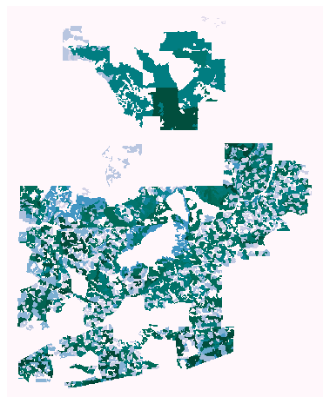

In [15]:
vegAgeData = importRaster('C:/Research/Osceola/SpatialData/ageraster_utm.tif')

vegAgeData[vegAgeData > 200] = 0

f, (ax1) = plt.subplots(1,1, figsize = (7,7))
plotRaster(vegAgeData, ax = ax1, cmap = 'PuBuGn', vmin = 0, vmax = 100)


### If we visualize the data in this raster as a histogram ..
This will be important when it comes to populate the areas of the map for which we do not have explicit age data.

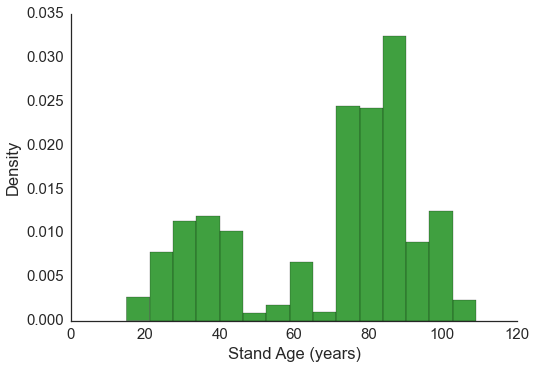

In [16]:
# the histogram of the data
n, bins, patches = plt.hist(vegAgeData[vegAgeData > 10], 15, normed=1, facecolor='green', alpha=0.75)
plt.xlabel('Stand Age (years)')
plt.ylabel('Density')
sns.despine()


### Strategy for assigning ages to raster cells
Figuring out the mean age for each stand isnt too hard. The problem is we need a map for each species type. Lets start by creating a map for the 'Not Swamp' ecoregion. Since these will be primarily single or dual age, and they will be primarily longleaf and slashpine. This is a simple take the age data where we have it, otherwise grab an age at random from the distribution we created above.

In [19]:


# Create some useful rasters

# We need a 'is this cell simulated' raster
# If the cell is simulated, make it a 1
ecoMask = importRaster('H:\OsceolaEcoregions.tif')
ecoMask[ecoMask > 0] = 1

height, width = ecoMask.shape

# We need a blank template raster that we can write over
# No data cells we'll write to 5
initCom = importRaster('H:\OsceolaEcoregions.tif')
initCom[initCom < 5] = 0

for row in range(0,height-1):
    for col in range(0,width-1):
        if osceolaEcoregions[row, col] == 2:
            initCom[row,col] = 0
        if osceolaEcoregions[row, col] == 1:
            if vegAgeData[row,col] != 0:
                initCom[row,col] = vegAgeData[row,col]
            else:
                initCom[row,col] = random.choice(vegAgeData[vegAgeData > 0].ravel())

#### Looks like it sort of worked
The ecoregions map in AX1 shows WHITE where we wanted to fill in age data from AX2. Basically we should have ages from AX2 in AX3 wherever we have WHITE in AX1 ... super clear

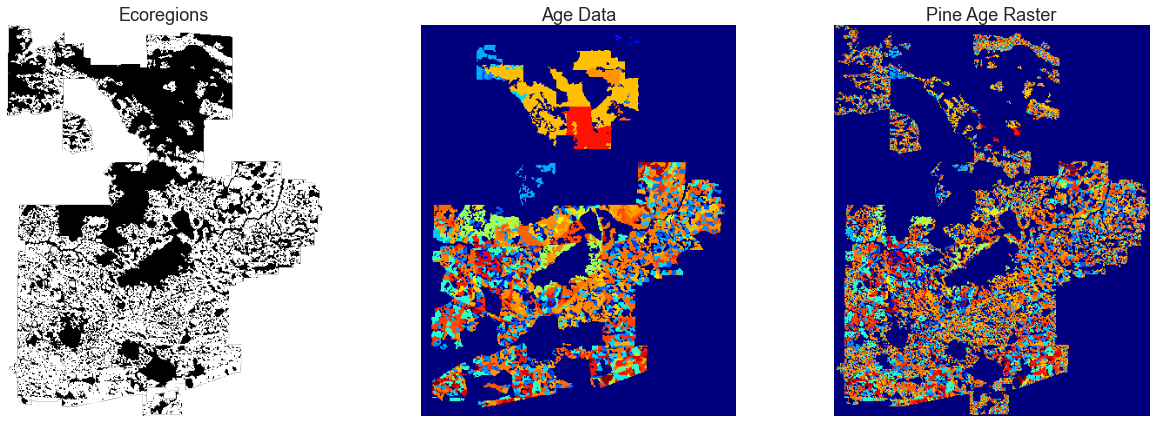

In [21]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (21,7))
plotRaster(osceolaEcoregions, ax = ax1, vmin = 1, vmax = 2)
plotRaster(vegAgeData, ax = ax2, cmap = 'jet')
plotRaster(initCom, ax = ax3, cmap = 'jet')
ax1.set_title('Ecoregions')
ax2.set_title('Age Data')
ax3.set_title('Pine Age Raster')


### We need to discretize our Pine Age raster
The fastest way to do this is numpy.round()

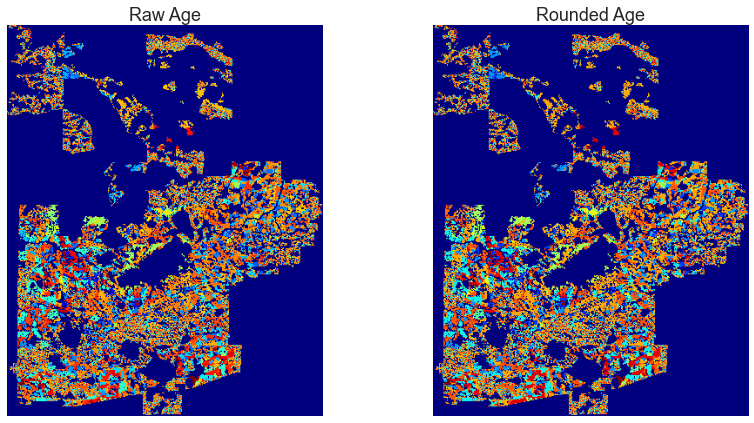

In [22]:
roundedPineAge = np.round(initCom, -1)

f, (ax1, ax2) = plt.subplots(1,2, figsize = (14,7))
plotRaster(initCom, ax = ax1, cmap = 'jet')
plotRaster(roundedPineAge, ax = ax2, cmap = 'jet')
ax1.set_title('Raw Age')
ax2.set_title('Rounded Age')

### We have a challenge now, with respect to the odd way LANDIS-II handles the IC
Specifically, we have a set of unique pine max ages, namely those listed  below:

In [23]:
np.unique(roundedPineAge)

array([   0.,   20.,   30.,   40.,   50.,   60.,   70.,   80.,   90.,
        100.,  110.])

These 10 unique stand ages should represent the cohort composition for three pine species, yet if we were to assign map codes to any of the above grid cells, we need to account for the fact that a mapcode with an 80 yr old cohort with and without a 10 and 30 yr old cohort is unique from mapcodes that lack the 10, the 30, or any other species. How do we handle then creating map codes that link to unique lists of multiple species and cohort ages?

One way is to basically concatenate multiple ages onto the existing age value, using a simple set of logic rules. For instance, a 20 yr cohort has a probability to gaining an additional 20 yr cohort, turning 20 into 2020, or a 50 yr cohort may gain a 20 and a 10 making it 502010. The challenge here then becomes the 100 and 110 yr old cohorts -- how do we distinguish them so that parsing down the line separates out the three character age correctly? One solution is this: for all initial age raster cells containing a 100 yr old cohort, create a flag is.old, where if is.old == True, parse the age code differently.

### After trying that solution out for a bit, it sucked.
I hate to do it because it always feels like a pain in the ass, but I need to create a list of dicts, and use the stand age from the raster above to govern what additional items in the dict get populated. The function buildMapCode below does just that. Basically, we create a database of species age combinations, where the likelihood of additional cohorts is a function of the empirically derived stand age,a nd the dominant species composition across the Osceola. We almost always populate the pine cohorts with one or more cohorts of palmetto as well. This function only creates, essentially a database -- it is not spatially explicit. We generate the spatially explicit product by using this function over a raster of stand ages.

In [24]:
def buildMapCode(standAge):
    # Start by creating a dictionary for the pines for each map code
    # This is empty initially save the longleaf stand age from our age raster
    mapAge = int(standAge)
    leaf = [mapAge]
    slash = [ ]
    lob = [ ]
    palm = [ ]
    # Populate each dictionary item based on the stand age and some probabilities
    if mapAge >= 80:
        
        # Probability that the stand contains equal age slash and or lob
        if np.random.random_sample() > 0.3:
            slash.append(mapAge)
        if np.random.random_sample() > 0.95:
            lob.append(mapAge)

        # Probability that the stand is a 'dual age' stand
        if np.random.random_sample() > 0.7:
            leaf.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.95:
            slash.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.995:
            lob.append(np.random.choice([30,40,50]))

        # Probability that the stand contains 10 yr regen
        if np.random.random_sample() > 0.5:
            leaf.append(10)
        if np.random.random_sample() > 0.5:
            slash.append(10)
        if np.random.random_sample() > 0.9:
            lob.append(10)
           
    elif (mapAge >= 20) & (mapAge < 80):
        # Probability that the stand contains equal age slash and or lob
        if np.random.random_sample() > 0.3:
            slash.append(mapAge)
        if np.random.random_sample() > 0.8:
            lob.append(mapAge)
            
        # Probability that the stand is a 'dual age' stand
        # This is very low, given the age data we have comes from
        # planting ages.
        if np.random.random_sample() > 0.85:
            leaf.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.99:
            slash.append(np.random.choice([30,40,50]))
        if np.random.random_sample() > 0.999:
            lob.append(np.random.choice([30,40,50]))

        # Probability that the stand contains 10 yr regen
        if np.random.random_sample() > 0.5:
            leaf.append(10)      
        if np.random.random_sample() > 0.5:
            slash.append(10)
        if np.random.random_sample() > 0.85:
            lob.append(10)
            
    #if np.random.random_sample() < 0.95:
    palm.append(np.random.choice([[10],[10,20],[10,20,30],[10,20,30,40],[10,20,30,40,50]]))
    mapcode = {'longleaf':leaf, 'slashpine':slash, 'loblolly':lob, 'palmetto':palm[0]}

    return mapcode

### Now we step over our age raster, and reference the mapcode database.
This is a bit tricky, basically we take each grid cell for our initial age raster and use it to generate a map code with the above function. However, we need to constantly check if we have an assemblage of species and age cohorts that have already been assigned a mapcode in the past (since we want to use the same map codes for multiple grid cells is possible). This means we have to be checking the new entries in our mapcode database against all existing map codes -- but the list grows with each loop iteration, and the search will take more time. The code below works -- but there's probably a slicker way to handle it.

In [38]:
# Conduct some benchmarking
import time
tic = time.clock()

ICRaster = importRaster('H:\OsceolaEcoregions.tif')
allIC = [ ]
allUniqueCodes = [ ]
allUniqueCodesMC = [ ]
uniqueIC = 3

for row in range(0,height-1):
    for col in range(0,width-1):
        if osceolaEcoregions[row, col] == 1:
            cellIC = buildMapCode(roundedPineAge[row,col])
            withCodes = dict(cellIC)

            if uniqueIC == 3:
                ICRaster[row,col] = uniqueIC
                withCodes['MapCode'] = uniqueIC
                allUniqueCodesMC.append(withCodes)
                allUniqueCodes.append(cellIC)
                uniqueIC += 1
                
            if uniqueIC > 3:
                if cellIC not in allUniqueCodes:
                    withCodes['MapCode'] = uniqueIC
                    allUniqueCodes.append(cellIC)
                    allUniqueCodesMC.append(withCodes)
                    ICRaster[row,col] = uniqueIC
                    uniqueIC += 1
                       
                else:
                    # This bit is terribly optimized ... but for now its fine
                    bools = []
                    for code in allUniqueCodes:
                        bools.append(code == cellIC)
                    oldCode = [i for i, x in enumerate(bools) if x]
                    ICRaster[row,col] = allUniqueCodesMC[oldCode[0]]['MapCode']
toc = time.clock()
print('iterative mapcode generation and redundancy searching took {0:.1f} seconds'.format(uniqueIC))
print('and resulted in {0:.1f} unique mapcodes').format(uniqueIC-2)                   


iterative mapcode generation and redundancy searching took 4551.0 seconds
and resulted in 4549.0 unique mapcodes


### This ended up working out
And now we have a raster of lookuptable values that references back to a dictionary of species and age cohorts. That means if we need to we could always produce a raster of the IC starting age by species -- this includes mean age, variance of age, etc. Pretty cool. Didn't take too long to sort through the growing list either, but we still have to fill in the gaps for the swamps -- which will be a similar process.

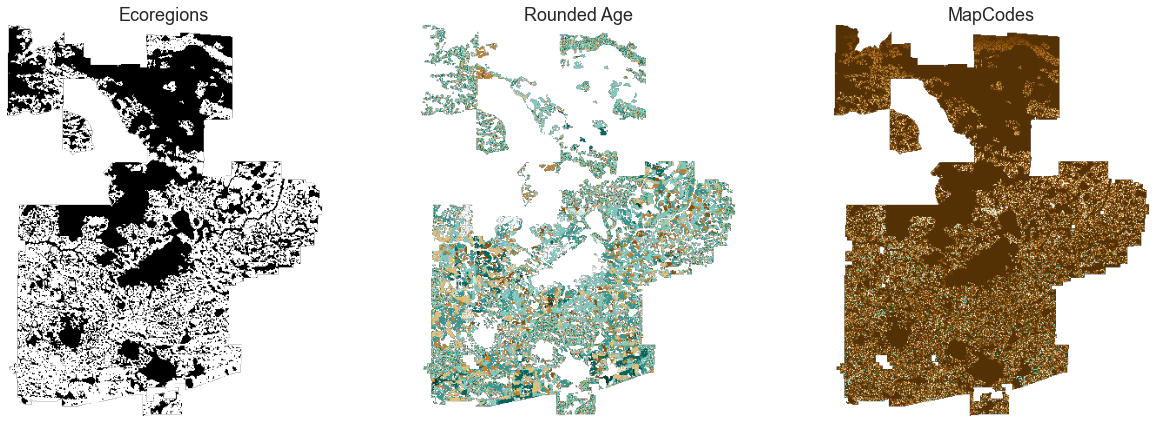

In [41]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (21,7))
roundedPineAge[roundedPineAge == 0] = np.nan
ICRaster[ICRaster == 0] = np.nan

plotRaster(osceolaEcoregions, ax = ax1, vmin = 1, vmax = 2)
plotRaster(roundedPineAge, ax = ax2, cmap = 'BrBG', vmin = 10, vmax = 110)
plotRaster(ICRaster, ax = ax3, cmap = 'BrBG', vmin = 1, vmax = 4500)

ax1.set_title('Ecoregions')
ax2.set_title('Rounded Age')
ax3.set_title('MapCodes')

### Now we have to do some writing.
The basic format of the initial communities file is a map code, followed by a list of species, and their respective ages. We can iterate over the dinctionary of unique mapcodes, and write down the species followed by their age cohorts. 

In [109]:
import csv

# Specify the name of the file to create
new_ic_filename = 'C:/Research/Osceola/ic_osceola.txt'
with open(new_ic_filename, "w") as f_new:
    # Write the header of the file, as well as the date the file was created
    f_new.write('LandisData   "Initial Communities" \n')
    f_new.write('>> Generated ' + time.strftime("%m/%d/%Y") + '\n')
    f_new.write('\n')
    
    # Step through the map codes and write the mapcode name comment, followed by the non-zero 
    # species cohorts
    for code in allUniqueCodesMC:
        codestr = str(code['MapCode'])
        codeformat = 'MapCode ' + codestr
        f_new.write('>> MixedPine_' + codestr + '\n')
        f_new.write(codeformat + '\n')
        for key in ['palmetto', 'loblolly', 'slashpine', 'longleaf']:
            if len(code[key]) > 0:
                codeString = key + ' ' + str(code[key]) + '\n'
                f_new.write(codeString.translate(None, '[,]'))
        f_new.write('\n')


### The last step is to populate the swamp data with the remaining FIA plots
that we gathered from the surrounding regions. We have 200+ plots with cyprus data -- we just need to decide to randomly assign a code to each of those plots 

###Data driven fire history description
Using a similar approach as in the Dink, we'll plot up the recent fire scars (back to 1998 in this case, its not exactly CalFire) and create a distribution of their size and frequency in an effort to generate the initial params for the DFFS. 

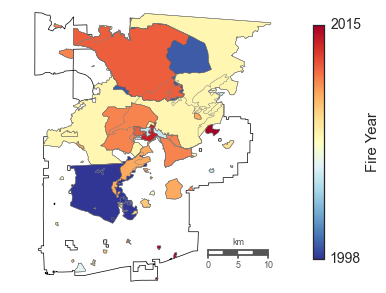

In [42]:
f, ax = plt.subplots(1,1, figsize = (10,5))
sns.set_style('white')
sns.despine(left = True, bottom = True)

coords, midlat, midlon = getShpGeom('H:\OSCF_FH.shp')

m = Basemap(llcrnrlon=coords[0]-0.05,llcrnrlat=coords[1],
            urcrnrlon=coords[2],urcrnrlat=coords[3],
             resolution='i', projection='tmerc', 
            lat_0 = midlat, lon_0 = midlon, ax = ax);

m.readshapefile(shapeDir + 'OsceolaShape', 'Osceola',
    color='black', linewidth = 0.7, zorder=0);

m.readshapefile('H:\OSCF_FH', 'firehist',
    color='gray', zorder=5);

m.drawmapscale(
    coords[0] + 0.35, coords[1] + 0.05,
    coords[0], coords[1],
    10.,
    barstyle='fancy', 
    labelstyle='simple',
    fillcolor1='w', 
    fillcolor2='#555555',
    fontcolor='#555555',
    zorder=1);

# set up a map dataframe
fireslist = []
df_map = pd.DataFrame({
    'poly': [Polygon(xy) for xy in m.firehist]})
for shape in enumerate(df_map['poly']):
    keys, values = m.firehist_info[shape[0]].keys(),m.firehist_info[shape[0]].values()
    fireslist.append(values[26])
df_map['FireRegion'] = fireslist
df_map['area_m'] = df_map['poly'].map(lambda x: x.area)
df_map['area_km'] = df_map['area_m'] / 100000
df_map['patches'] = df_map['poly'].map(lambda x: PolygonPatch(
    x, ec='#787878', lw=.25))

fireslist = map(int, fireslist)
p = PatchCollection(df_map.patches,cmap=plt.get_cmap('RdYlBu_r'))
p.set_array(np.array(fireslist))
p.set_clim([np.ma.min(fireslist),np.ma.max(fireslist)])
ax.add_collection(p)


cbaxes = f.add_axes([0.75, 0.2, 0.015, 0.65]) 
cbar = plt.colorbar(p, cax = cbaxes, ticks = [1998,2015])
cbar.ax.tick_params(labelsize=14)
cbar.ax.set_ylabel('Fire Year', fontsize = 15)
plt.savefig('FireHistory_Osceola.tif', dpi = 300)

#### Quickly generate the lognormal distribution derived from the data above

C:\Anaconda\lib\site-packages\IPython\kernel\__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


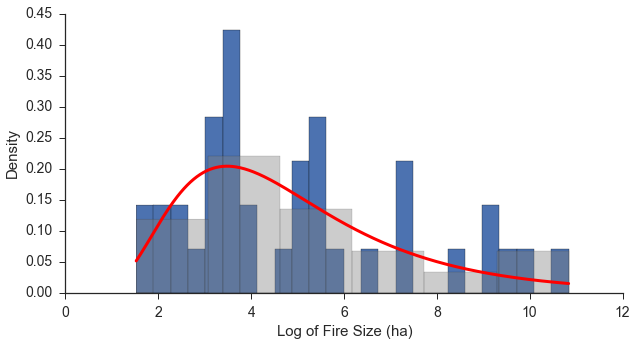

In [45]:
metadata = pd.read_csv('H:\OSCF_FH_metadata.txt')
# Data driven approach:
metadata['HECTARES'] = metadata.GIS_AC * 0.404686
firesizeMu = np.log(metadata.HECTARES).mean()
firesizeSd = np.log(metadata.HECTARES).std()
# Modeled approach:
# Limit fires to those > 1 ha
metadata.HECTARES[metadata.HECTARES < 1] = np.nan
firesize = np.log(metadata.HECTARES).dropna()
rvs = firesize # Generate some random variates as data

shape, loc, scale = stats.lognorm.fit(rvs, floc=0) # Fit a curve to the variates
mu = np.log(scale) # Mean of log(X)
sigma = shape # Standard deviation of log(X)
M = np.exp(mu) # Geometric mean == median
s = np.exp(sigma) # Geometric standard deviation

# Plot figure of results
f, ax = plt.subplots(1,1, figsize = (10,5))
n, bins, patches = ax.hist(rvs, bins=25, normed=True) # Plot histogram

x = np.linspace(rvs.min(), rvs.max(), num=400)
g = sns.distplot(rvs, kde=False, ax = ax, 
                 color = 'gray', norm_hist = True);
plt.plot(x, stats.lognorm.pdf(x, shape, 
            loc=0, scale=scale), 'r', linewidth=3) # Plot fitted curve
ax.set_xlabel('Log of Fire Size (ha)', fontsize = 15)
ax.set_ylabel('Density', fontsize = 15)
sns.despine()
ax.patch.set_facecolor('none')
sns.set_style('ticks')
sns.set_context('notebook', font_scale=1.4)

plt.savefig('FireHistory_Osceola_RVS.tif', dpi = 300)